# 1. Load goodreads data
- Package imports
- Load data
- Data cleaning
- save as `01_cleaned_goodreads_data.csv`


In [1]:
import pandas as pd

sourcefolder = '../data/sources'
outputfolder = '../data/outputs'

In [38]:

# load goodreads data, clean whitespace from author names and filter out unread books
df = pd.read_csv(sourcefolder+"/goodreads_library_export.csv")

df['Author'] = df['Author'].str.replace(r'\s+', ' ', regex=True)
df['Author'].unique()
df=df[df['Read Count'] > 0]

# collapse the list on author and add book count and average 'Average Rating'
# the title should be kept as a list for further processing
df = df.groupby('Author').agg({'Title': list, 'Average Rating': 'mean'}).reset_index()

df['Books'] = df['Title']
df.drop('Title', axis=1, inplace=True)
df['Book Count'] = df['Books'].apply(len)

df.to_csv(outputfolder+'/01_cleaned_goodreads_data.csv')

# 2 Author country lookup
We will use the WikiData SPARQL api to get the country of the authors.
This is the best I can find.
And we need to correct the country of the authors in the dataset manually with overrides afterwards.

The author countries is saved to `02_author_countries.csv`

## Function to do SPARQL lookup in wikidata.org

In [39]:
import sys
import re
from SPARQLWrapper import SPARQLWrapper, JSON

def execute_query(endpoint_url, query):
    user_agent = "WDQS-example Python/%s.%s (christian@dalager.com)" % (
        sys.version_info[0],
        sys.version_info[1],
    )
    sparql = SPARQLWrapper(endpoint_url, agent=user_agent)
    sparql.setQuery(query)
    sparql.setReturnFormat(JSON)
    return sparql.query().convert()


def get_author_countries(author_name):
    author_name = re.sub(r"\s+", " ", author_name)
    author_name = author_name.strip()

    endpoint_url = "https://query.wikidata.org/sparql"

    query = (
        """SELECT ?countryLabel WHERE {
        ?author ?label "%s"@en.
        ?author wdt:P27 ?country.
        SERVICE wikibase:label { bd:serviceParam wikibase:language "[AUTO_LANGUAGE],en". }
        }"""
        % author_name
    )

    results = execute_query(endpoint_url, query)

    bindings = results["results"]["bindings"]
    countries = list({entry["countryLabel"]["value"] for entry in bindings})

    return countries


## Perform the lookup
It will take around 1-2 minutes for 370 authors
And the data will be saved in a csv file for future use.

In [40]:
# extract all author names from "Author" to a unique list

df = pd.read_csv(outputfolder+'/01_cleaned_goodreads_data.csv')

authors = df['Author'].unique()

print(f'Requesting {len(authors)} authors')

# Create a list to collect author and their countries
author_country_list = []

# Iterate over all authors and get the countries  (1.5 min)
for author in authors:
    countries = get_author_countries(author)  # Make sure this returns a list of countries
    author_country_list.append({'Author': author, 'Countries': countries})

df_authorcountries = pd.DataFrame(author_country_list)
    
# save to csv
df_authorcountries.to_csv(outputfolder+'/02_author_countries.csv', index=False)


Requesting 369 authors


# Begynd at arbejde med listerne

# 3. Manually located authors' countries in the dataset

The wikipedia data is not perfect, so we need to manually correct the data.
I have a correction list for my authors in `/data/sources/author_country_corrections.csv`

Saves the corrected list as `04_country_corrected_author.csv`

In [73]:
import ast
df_authorcountries = pd.read_csv(outputfolder+'/02_author_countries.csv')
df_authorcountries['Countries'] = df_authorcountries['Countries'].apply(ast.literal_eval)

df_manually_placed = pd.read_csv(sourcefolder+"/author_country_corrections.csv")
df_manually_placed['Countries'] = df_manually_placed['Countries'].apply(ast.literal_eval)

df_manually_placed.rename(
    columns={"Countries": "Countries_Manually_Placed"}, inplace=True
)
merged_df = pd.merge(
    df_authorcountries,
    df_manually_placed[["Author", "Countries_Manually_Placed"]],
    on="Author",
    how="left",
    validate="1:1",
)
# Replace the 'Countries' column with the corrected countries where available
merged_df["Countries"] = merged_df["Countries_Manually_Placed"].fillna(
    merged_df["Countries"]
)

# Drop the 'Countries_Manually_Placed' column if you don't need it anymore
df_authorcountries = merged_df.drop(columns=["Countries_Manually_Placed"])

df_authorcountries.to_csv(outputfolder+'/04_country_corrected_authors.csv', index=False)

## Map the variants of country names to the standard names

The country names from wikidata are standardized, so we need to do that.

Outputs `05_author_countries_standardized.csv`

In [42]:
# Define a mapping from old country names to new country names
country_mapping = {
    'Ancient Rome': 'Italy',
    'Austria-Hungary': 'Austria',
    'Cisleithania': 'Austria',
    'Classical Athens': 'Greece',
    'Czechoslovakia': 'Czech Republic',
    'Dutch Republic': 'Netherlands',
    'England': 'United Kingdom',
    'German Empire': 'Germany',
    'Kingdom of Denmark': 'Denmark',
    'Kingdom of England': 'United Kingdom',
    'Kingdom of Great Britain': 'United Kingdom',
    'Kingdom of Italy': 'Italy',
    'Kingdom of the Netherlands': 'Netherlands',
    'Nazi Germany': 'Germany',
    'Russian Empire': 'Russia',
    'Russian Socialist Federative Soviet Republic': 'Russia',
    'Russian Soviet Federative Socialist Republic': 'Russia',
    'Scotland': 'United Kingdom',
    'United Kingdom of Great Britain and Ireland': 'United Kingdom',
    'Ireland':'Republic of Ireland',
    'Weimar Republic': 'Germany',
}

# Function to clean country names
def clean_country_list(country_list):
    replaced= [country_mapping.get(country, country) for country in country_list if country_mapping.get(country, country) is not None]
    return list(set(replaced))

# Apply the function to the 'Countries' column
df_authorcountries['Countries'] = df_authorcountries['Countries'].apply(clean_country_list)

df_authorcountries.to_csv(outputfolder+'/05_author_countries_standardized.csv', index=False)


# Gender enriched data

I have manually added gender-info to the authors in the dataset, saved in `author_genders.csv`.

The data was not i wikipedia and given the short list of authors, I have manually added gender information to the authors.

This is in many ways not perfect, and even though I have tried to be as thorough as possible, there might be som errors.

The gender information applied is binary, which will not represent the authors own perspective in all cases, and that is not the intention either.

In [ ]:
df_genders = pd.read_csv(sourcefolder+'/author_genders.csv')


# Complete the final dataset

Combining my booklist with country and gender information.

In [68]:
df_authorcountries = pd.read_csv(outputfolder+'/04_country_corrected_authors.csv')
df_genders = pd.read_csv(sourcefolder+'/author_genders.csv')
df_mybooks = pd.read_csv(outputfolder+'/01_cleaned_goodreads_data.csv')

df_final = pd.merge(df_mybooks, df_authorcountries, on='Author', how='left', validate='1:1')
df_final = df_final.merge(df_genders, on='Author', how='left', validate='1:1')

df_final['Countries'] = df_final['Countries'].apply(ast.literal_eval)
df_final['Books'] = df_final['Books'].apply(ast.literal_eval)

df_final.to_csv(outputfolder+'/05_final_data.csv', index=False)


# Show me the countries!

In [70]:
# list of uniqe countries
import ast
df_final = pd.read_csv(outputfolder+'/05_final_data.csv')
df_final['Countries'] = df_final['Countries'].apply(ast.literal_eval)
df_final['Books'] = df_final['Books'].apply(ast.literal_eval)

# order by book count
df_final = df_final.sort_values(by='Book Count', ascending=False)

# print the list of books from "Nnedi Okorafor"
okorafor=df_final[df_final['Author'] == 'Nnedi Okorafor']['Countries']
okorafor
#parsed = ast.literal_eval(okorafor.iloc[0])
# print okorafor book per line
#parsed
for country in okorafor.iloc[0]:
    print(country)


# parse array



[
'
U
n
i
t
e
d
 
S
t
a
t
e
s
 
o
f
 
A
m
e
r
i
c
a
'
,
 
'
N
i
g
e
r
i
a
'
]


# Barchart

[
'
U
n
i
t
e
d
 
K
i
n
g
d
o
m
'
,
 
'
R
e
p
u
b
l
i
c
 
o
f
 
I
r
e
l
a
n
d
'
]
[
'
U
n
i
t
e
d
 
K
i
n
g
d
o
m
'
]
[
'
U
n
i
t
e
d
 
S
t
a
t
e
s
 
o
f
 
A
m
e
r
i
c
a
'
]
[
'
U
n
i
t
e
d
 
S
t
a
t
e
s
 
o
f
 
A
m
e
r
i
c
a
'
,
 
'
N
i
g
e
r
i
a
'
]
[
'
U
n
i
t
e
d
 
K
i
n
g
d
o
m
'
]
[
'
U
n
i
t
e
d
 
S
t
a
t
e
s
 
o
f
 
A
m
e
r
i
c
a
'
]
[
'
I
t
a
l
y
'
,
 
'
K
i
n
g
d
o
m
 
o
f
 
I
t
a
l
y
'
]
[
'
U
n
i
t
e
d
 
S
t
a
t
e
s
 
o
f
 
A
m
e
r
i
c
a
'
]
[
'
U
n
i
t
e
d
 
K
i
n
g
d
o
m
'
]
[
'
U
n
i
t
e
d
 
S
t
a
t
e
s
 
o
f
 
A
m
e
r
i
c
a
'
]
[
]
[
'
N
o
r
w
a
y
'
]
[
'
J
a
p
a
n
'
]
[
'
U
n
i
t
e
d
 
K
i
n
g
d
o
m
'
]
[
'
U
n
i
t
e
d
 
K
i
n
g
d
o
m
'
]
[
'
N
o
r
w
a
y
'
]
[
'
K
i
n
g
d
o
m
 
o
f
 
D
e
n
m
a
r
k
'
]
[
'
U
n
i
t
e
d
 
K
i
n
g
d
o
m
'
]
[
'
U
n
i
t
e
d
 
S
t
a
t
e
s
 
o
f
 
A
m
e
r
i
c
a
'
]
[
'
U
n
i
t
e
d
 
S
t
a
t
e
s
 
o
f
 
A
m
e
r
i
c
a
'
]
[
'
U
n
i
t
e
d
 
S
t
a
t
e
s
 
o
f
 
A
m
e
r
i
c
a
'
]
[
'
U
n
i
t
e
d
 
K
i
n
g
d
o
m
'
]
[
'
U
n
i
t
e
d
 
S
t
a
t
e
s
 


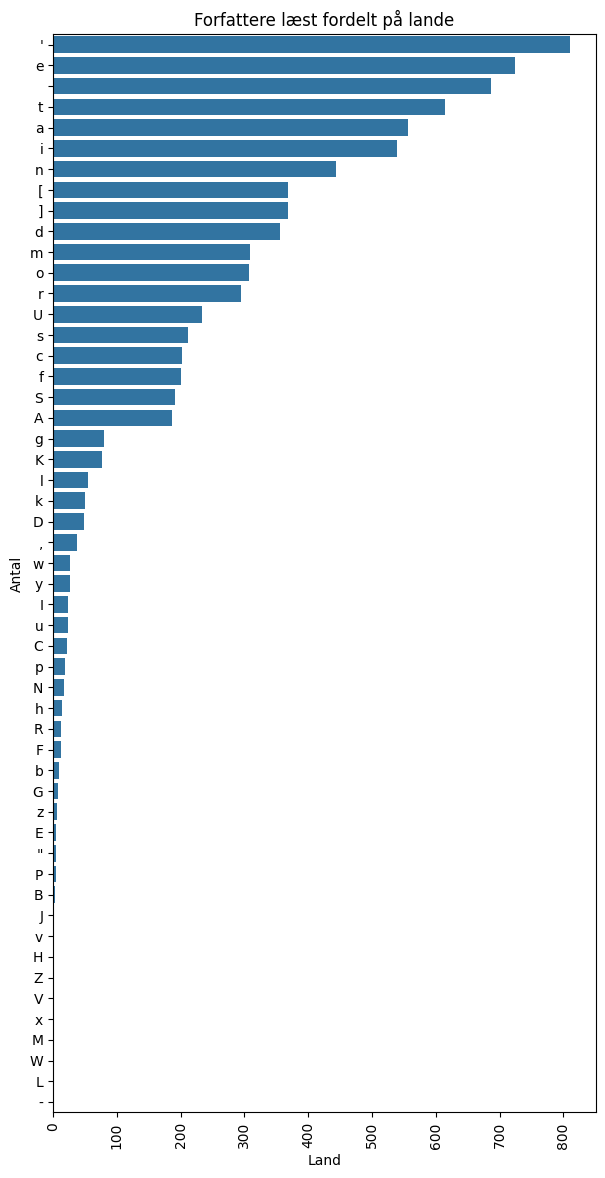

In [61]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict

# Aggregate the data
country_count = defaultdict(int)
for countries in df_final['Countries']:
    for country in countries:
                country_count[country] += 1



# Convert to DataFrame for plotting
country_df = pd.DataFrame(list(country_count.items()), columns=['Country', 'Count'])

# Bar Chart
# plt.figure(figsize=(14, 7))
# sns.barplot(x='Count', y='Country', data=country_df.sort_values(by='Count', ascending=False))
# plt.title('Forfattere læst fordelt på lande')
# plt.xlabel('Antal')
# plt.ylabel('Land')
# plt.show()


# remake barchart to vertical
plt.figure(figsize=(7, 14))
sns.barplot(x='Count', y='Country', data=country_df.sort_values(by='Count', ascending=False))
plt.title('Forfattere læst fordelt på lande')
plt.ylabel('Antal')
plt.xlabel('Land')
plt.xticks(rotation=90)
plt.show()






# Gender mapping
Load gender list and join dataframes

In [54]:
import pandas as pd
df_genders = pd.read_csv('../data/author_genders.csv')

df_authors = pd.read_csv('../data/myauthorlist_with_countries_and_books.csv')
df = df_authors.merge(df_genders, on='Author', how='left', validate='1:1')

df.to_csv('../data/myauthorlist_with_countries_and_books_and_genders.csv', index=False)


In [55]:
df

,Author,Average Rating,Books,Book Count,Countries,Gender
0,A.G. Riddle,3.876667,"['Departure', 'The Atlantis Plague (The Origin...",5,['United States of America'],M
1,Adam Lashinsky,3.830000,"[""Inside Apple -- From Steve Jobs Down to the ...",1,['United States of America'],M
2,Adrian Tchaikovsky,4.300000,"['Children of Time (Children of Time', '#1)']",2,['United Kingdom'],M
3,Agatha Christie,4.280000,['And Then There Were None'],1,['United Kingdom'],F
4,Alan Moore,4.380000,['Watchmen'],1,['United Kingdom'],M
...,...,...,...,...,...,...
364,Yann Martel,3.940000,['Life of Pi'],1,['Canada'],M
365,Yuval Noah Harari,4.360000,['Sapiens: A Brief History of Humankind'],1,['Israel'],M
366,bell hooks,4.370000,"['The Will to Change: Men', 'Masculinity', 'an...",3,['United States of America'],F
367,Ágota Kristóf,4.410000,"['The Notebook', 'The Proof', 'The Third Lie: ...",3,"['Switzerland', 'Hungary']",F


,Gender,Book Count,Author Count,% of Book Count,% of Author Count
0,F,187,83,19.101124,22.493225
1,M,792,286,80.898876,77.506775


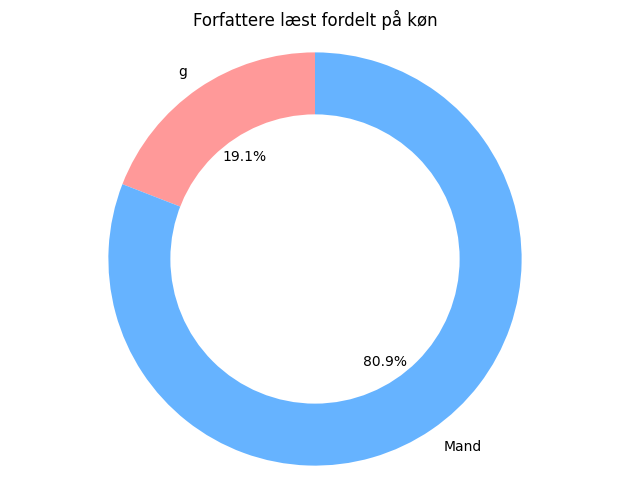

In [58]:
# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = ['g', 'Mand']
sizes = g['% of Book Count']
#colors
colors = ['#ff9999','#66b3ff','#99ff99','#ffcc99']

fig1, ax1 = plt.subplots()
ax1.pie(sizes, colors = colors, labels=labels, autopct='%1.1f%%', startangle=90)
#draw circle
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
# Equal aspect ratio ensures that pie is drawn as a circle
ax1.axis('equal')
plt.tight_layout()

plt.title('Forfattere læst fordelt på køn')
plt.show()